In [7]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import os
import time

from keras.models import Sequential, Model,load_model
from keras.layers import Dense, Flatten, Reshape, Conv2D, MaxPool2D, Conv2DTranspose, BatchNormalization, Dropout, LeakyReLU, Concatenate, Input, Embedding
from keras.optimizers import Adam, SGD
from keras.losses import MeanSquaredError
from keras import activations
from tensorflow.keras.utils import plot_model # for plotting model diagram

from sklearn.preprocessing import MinMaxScaler
from astroNN.datasets import load_galaxy10

from tensorflow.keras import utils
import tensorflow as tf
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()


In [18]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10736399397341241102
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4772069376
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6826569002973542278
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [3]:
import tensorflow as tf
print(tf.__version__)

2.12.1


In [ ]:
# with h5py.File('Galaxy10_DECals.h5', 'r') as h5_file:
#     # Odczytaj dane ze zbiorów danych
#     ans_data = h5_file['ans'][:]
#     dec_data = h5_file['dec'][:]
#     images_data = h5_file['images'][:]
#     pxscale_data = h5_file['pxscale'][:]
#     ra_data = h5_file['ra'][:]
#     redshift_data = h5_file['redshift'][:]

# # Tworzenie DataFrame z danymi
# data_dict = {
#     'ans': ans_data,
#     'dec': dec_data,
#     'images': images_data,
#     'pxscale': pxscale_data,
#     'ra': ra_data,
#     'redshift': redshift_data
# }

# df = pd.DataFrame(data_dict)

In [2]:
%%time
# # To get the images and labels from file
with h5py.File('../Galaxy10_DECals.h5', 'r') as F:
    images = np.array(F['images'])[7940:]
    labels = np.array(F['ans'])[7940:]

# To convert the labels to categorical 10 classes
# labels = utils.to_categorical(labels, 10)

# To convert to desirable type
# labels = labels.astype(np.uint8)
images = images.astype(np.float32)
labels_names = ["Disturbed Galaxies", "Merging Galaxies", "Round Smooth Galaxies", "In-between Round Smooth Galaxies", "Cigar Shaped Smooth Galaxies",
            "Barred Spiral Galaxies", "Unbarred Tight Spiral Galaxies", "Unbarred Loose Spiral Galaxies", "Edge-on Galaxies without Bulge", "Edge-on Galaxies with Bulge"]

CPU times: user 36.8 s, sys: 4.08 s, total: 40.9 s
Wall time: 59.9 s


In [3]:
for name, count in zip(labels_names, np.unique(labels[:], axis=0, return_counts=True)[1]):
    print(f"{name}: {count}")

Disturbed Galaxies: 2043
Merging Galaxies: 1829
Round Smooth Galaxies: 2628
In-between Round Smooth Galaxies: 1423
Cigar Shaped Smooth Galaxies: 1873


In [3]:
for name, count in zip(labels_names, np.unique(labels[:], axis=0, return_counts=True)[1]):
    print(f"{name}: {count}")

Disturbed Galaxies: 1081
Merging Galaxies: 1853
Round Smooth Galaxies: 2645
In-between Round Smooth Galaxies: 2027
Cigar Shaped Smooth Galaxies: 334
Barred Spiral Galaxies: 2043
Unbarred Tight Spiral Galaxies: 1829
Unbarred Loose Spiral Galaxies: 2628
Edge-on Galaxies without Bulge: 1423
Edge-on Galaxies with Bulge: 1873


In [7]:
[7940:]

array([5, 5, 5, ..., 9, 9, 9], dtype=uint8)

In [3]:
indexes = np.array([], dtype=np.int64)
for i in range(5,10):
    if i == 4:
        continue
    temp = np.where(labels == i)[0][:1000]
    indexes = np.concatenate((indexes, temp), axis=None)

In [4]:
indexes.shape

(5000,)

In [5]:
images = images[tuple(indexes), :]

In [6]:
images.shape

(5000, 256, 256, 3)

In [7]:
%%time
images = tf.data.Dataset.from_tensor_slices(images)

def resize_data(image):
  SIZE = (64,64)
  image = tf.image.resize(image, SIZE)
  image = tf.image.rgb_to_grayscale(image)
  image = tf.cast(image, dtype=tf.float32)
  image = (image / 127.5) - 1.0
  return image
  

images = images.map(resize_data)

Cause: Unable to locate the source code of <function resize_data at 0x7f52c02b9af0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function resize_data at 0x7f52c02b9af0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @t

In [8]:
CODINGS_SIZE = 100
BUFFER_SIZE = 5000
BATCH_SIZE = 32

images = images.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

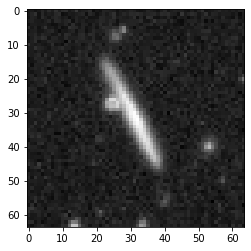

In [10]:
for image in images.take(1):  # only take first element of dataset
    plt.imshow(image[10].numpy(), cmap="gray")

# Model

In [22]:
generator_layer1 = Sequential([
    Dense(4 * 4 * 512, input_shape=[CODINGS_SIZE,], activation=LeakyReLU(0.2)),
    Reshape([4, 4, 512]),
    BatchNormalization()
])

generator_layer2 = Sequential([
    Dense(4*4, input_shape=[1,], activation=LeakyReLU(0.2)),
    Reshape([4, 4, 1]),
    BatchNormalization()
])

generator = Sequential([
    Concatenate([generator_layer1, generator_layer2]),
    Conv2DTranspose(filters=512, kernel_size=4, strides=2, padding="same", activation=LeakyReLU(0.2)),
    BatchNormalization(),
])

In [23]:
generator.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [20]:
plot_model(generator_layer1, show_shapes=True, show_layer_names=True, dpi=400)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [9]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator_layer1 = Sequential([
    Dense(4 * 4 * 512, input_shape=[codings_size,]),
    Reshape([4, 4, 512]),
    BatchNormalization()
    Conv2DTranspose(filters=512, kernel_size=4, strides=2, padding="same", activation=LeakyReLU(0.2)),
    BatchNormalization(),
    Conv2DTranspose(filters=256, kernel_size=4, strides=2, padding="same", activation=LeakyReLU(0.2)),
    BatchNormalization(),
    Conv2DTranspose(filters=128, kernel_size=4, strides=2, padding="same", activation=LeakyReLU(0.2)),
    BatchNormalization(),
    Conv2DTranspose(filters=1, kernel_size=4, strides=2, padding="same", activation="tanh"),
])

discriminator = Sequential([
    Conv2D(filters=64, kernel_size=4, strides=2, padding="same", activation=LeakyReLU(0.2), input_shape=[64, 64, 1]),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=4, strides=2, padding="same", activation=LeakyReLU(0.2)),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=4, strides=2, padding="same", activation=LeakyReLU(0.2)),
    BatchNormalization(),
    Conv2D(filters=512, kernel_size=4, strides=2, padding="same", activation=LeakyReLU(0.2)),
    BatchNormalization(),
    Flatten(),
    Dense(1, activation="sigmoid")
])



In [11]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              827392    
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 512)        2048      
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        4194816   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 512)        2048      
 hNormalization)                                                 
                                                        

In [12]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1088      
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524544    
                                                                 
 batch_normalization_6 (Batc  (None, 8, 8, 256)       

In [8]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.5, beta_2=0.999)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.5, beta_2=0.999)

In [36]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [9]:
EPOCHS = 50
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, codings_size])

In [10]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, codings_size])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [11]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_images(generator, epoch + 1, seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_images(generator,epochs,seed)

In [12]:
def generate_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  
  plt.show()

In [ ]:
%%time
time.sleep(5)
train(images, 2)

# DCGAN2

In [2]:
%%time
# # To get the images and labels from file
with h5py.File('../Galaxy10_DECals.h5', 'r') as F:
    images = np.array(F['images'])[:5000]
    # labels = np.array(F['ans'])

# To convert the labels to categorical 10 classes
# labels = utils.to_categorical(labels, 10)

# To convert to desirable type
# labels = labels.astype(np.uint8)
images = images.astype(np.float32)
labels_names = ["Disturbed Galaxies", "Merging Galaxies", "Round Smooth Galaxies", "In-between Round Smooth Galaxies", "Cigar Shaped Smooth Galaxies",
            "Barred Spiral Galaxies", "Unbarred Tight Spiral Galaxies", "Unbarred Loose Spiral Galaxies", "Edge-on Galaxies without Bulge", "Edge-on Galaxies with Bulge"]

CPU times: user 34 s, sys: 3.7 s, total: 37.7 s
Wall time: 55.4 s


In [3]:
images.shape

(5000, 256, 256, 3)

In [4]:
%%time
images = tf.data.Dataset.from_tensor_slices((images, labels))

def resize_data(image):
  SIZE = (64,64)
  image = tf.image.resize(image, SIZE)
  image = tf.image.rgb_to_grayscale(image)
  image = tf.cast(image, dtype=tf.float32)
  image = (image / 127.5) - 1.0
  return image
  

images = images.map(resize_data)

Cause: Unable to locate the source code of <function resize_data at 0x7fc54b5ac1f0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function resize_data at 0x7fc54b5ac1f0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @t

In [7]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32
images = images.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

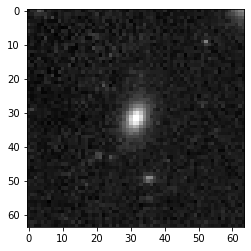

In [8]:
for image in images.take(1):  # only take first element of dataset
    plt.imshow(image[1].numpy(), cmap="gray")

In [8]:
codings_size = 100

generator = Sequential([
    Dense(8 * 8 * 512, input_shape=[codings_size,]),
    Reshape([8, 8, 512]),
    BatchNormalization(),
    Conv2DTranspose(filters=256, kernel_size=4, strides=2, padding="same", activation=LeakyReLU(0.2)),
    BatchNormalization(),
    Conv2DTranspose(filters=128, kernel_size=4, strides=2, padding="same", activation=LeakyReLU(0.2)),
    BatchNormalization(),
    Conv2DTranspose(filters=1, kernel_size=4, strides=2, padding="same", activation="tanh"),
])

discriminator = Sequential([
    Conv2D(filters=64, kernel_size=4, strides=2, padding="same", activation=LeakyReLU(0.2), input_shape=[64, 64, 1]),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=4, strides=2, padding="same", activation=LeakyReLU(0.2)),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=4, strides=2, padding="same", activation=LeakyReLU(0.2)),
    BatchNormalization(),
    Conv2D(filters=512, kernel_size=4, strides=2, padding="same", activation=LeakyReLU(0.2)),
    BatchNormalization(),
    Flatten(),
    Dense(1, activation="sigmoid")
])



In [10]:
gan = Sequential([generator, discriminator])
gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 1)         7651713   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 2766529   
                                                                 
Total params: 10,418,242
Trainable params: 10,413,506
Non-trainable params: 4,736
_________________________________________________________________


In [11]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=30):
  generator, discriminator = gan.layers
  for epoch in range(n_epochs):
      start = time.time()
      print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
      for X_batch in dataset:
          # phase 1 - training the discriminator
          noise = tf.random.normal(shape=[batch_size, codings_size])
          generated_images = generator(noise)
          X_batch = tf.cast(X_batch, tf.float32)
          X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
          y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
          discriminator.trainable = True
          discriminator.train_on_batch(X_fake_and_real, y1)
          # phase 2 - training the generator
          noise = tf.random.normal(shape=[batch_size, codings_size])
          y2 = tf.constant([[1.]] * batch_size)
          discriminator.trainable = False
          gan.train_on_batch(noise, y2)
      print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start)) 

In [12]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [15]:
%%time
train_gan(gan, images, BATCH_SIZE, codings_size, n_epochs=50)

Epoch 1/50
Time for epoch 1 is 44.21453619003296 sec
Epoch 2/50
Time for epoch 2 is 43.90914344787598 sec
Epoch 3/50
Time for epoch 3 is 44.462414503097534 sec
Epoch 4/50
Time for epoch 4 is 43.66151189804077 sec
Epoch 5/50
Time for epoch 5 is 43.94576096534729 sec
Epoch 6/50
Time for epoch 6 is 44.262691259384155 sec
Epoch 7/50
Time for epoch 7 is 44.056153297424316 sec
Epoch 8/50
Time for epoch 8 is 43.968929052352905 sec
Epoch 9/50
Time for epoch 9 is 44.122886180877686 sec
Epoch 10/50
Time for epoch 10 is 43.84881114959717 sec
Epoch 11/50
Time for epoch 11 is 44.19888091087341 sec
Epoch 12/50
Time for epoch 12 is 44.48023271560669 sec
Epoch 13/50
Time for epoch 13 is 43.934038400650024 sec
Epoch 14/50
Time for epoch 14 is 44.77587389945984 sec
Epoch 15/50
Time for epoch 15 is 44.01865530014038 sec
Epoch 16/50
Time for epoch 16 is 43.7162823677063 sec
Epoch 17/50
Time for epoch 17 is 43.92704367637634 sec
Epoch 18/50
Time for epoch 18 is 44.74990439414978 sec
Epoch 19/50
Time for ep

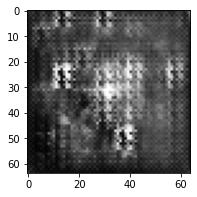

In [14]:
plt.figure(figsize=(3,3))
noise = tf.random.normal(shape=[BATCH_SIZE, 100])
img = np.array(generator(noise))
plt.imshow(img[0].reshape(64,64), cmap="gray")
plt.show()

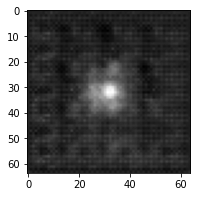

In [25]:
plt.figure(figsize=(3,3))
noise = tf.random.normal(shape=[BATCH_SIZE, 100])
img = np.array(generator(noise))
plt.imshow(img[0].reshape(64,64), cmap="gray")
plt.show()

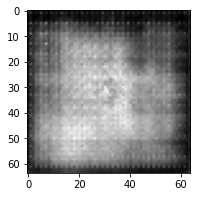

In [47]:
plt.figure(figsize=(3,3))
noise = tf.random.normal(shape=[BATCH_SIZE, 100])
img = np.array(generator(noise))
plt.imshow(img[0].reshape(64,64), cmap="gray")
plt.show()

# cGAN

In [ ]:
%%time
# # To get the images and labels from file
with h5py.File('../Galaxy10_DECals.h5', 'r') as F:
    images = np.array(F['images'])[7940:]
    labels = np.array(F['ans'])[7940:]

# To convert the labels to categorical 10 classes
# labels = utils.to_categorical(labels, 10)

# To convert to desirable type
# labels = labels.astype(np.uint8)
images = images.astype(np.float32)
labels_names = ["Disturbed Galaxies", "Merging Galaxies", "Round Smooth Galaxies", "In-between Round Smooth Galaxies", "Cigar Shaped Smooth Galaxies",
            "Barred Spiral Galaxies", "Unbarred Tight Spiral Galaxies", "Unbarred Loose Spiral Galaxies", "Edge-on Galaxies without Bulge", "Edge-on Galaxies with Bulge"]

In [ ]:
for name, count in zip(labels_names, np.unique(labels[:], axis=0, return_counts=True)[1]):
    print(f"{name}: {count}")

In [ ]:
%%time
images = tf.data.Dataset.from_tensor_slices(images)

def resize_data(image):
  SIZE = (64,64)
  image = tf.image.resize(image, SIZE)
  image = tf.image.rgb_to_grayscale(image)
  image = tf.cast(image, dtype=tf.float32)
  image = (image / 127.5) - 1.0
  return image
  

images = images.map(resize_data)

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32
images = images.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

In [ ]:
for image in images.take(1):  # only take first element of dataset
    plt.imshow(image[1].numpy(), cmap="gray")

In [9]:
def define_discriminator(in_shape=(64,64,1), n_classes=5):
 # label input
 in_label = Input(shape=(1,))
 # embedding for categorical input
 li = Embedding(n_classes, 50)(in_label)
 # scale up to image dimensions with linear activation
 n_nodes = 32 * 32
 li = Dense(n_nodes)(li)
 # reshape to additional channel
 li = Reshape((32, 32, 1))(li)
    
 # image input
 in_image = Input(shape=in_shape)
 in_image = Conv2D(filters=64, kernel_size=4, strides=2, padding="same", activation=LeakyReLU(0.2))(in_image)
 in_image = BatchNormalization()(in_image)
    
 # concat label as a channel
 merge = Concatenate()([in_image, li])

 fe = Conv2D(filters=128, kernel_size=4, strides=2, padding="same", activation=LeakyReLU(0.2))(merge)
 fe = BatchNormalization()(fe)
 fe = Conv2D(filters=256, kernel_size=4, strides=2, padding="same", activation=LeakyReLU(0.2))(fe)
 fe = BatchNormalization()(fe)
 fe = Conv2D(filters=512, kernel_size=4, strides=2, padding="same", activation=LeakyReLU(0.2))(fe)
 fe = BatchNormalization()(fe)
 fe = Flatten()(fe)
 out_layer = Dense(1, activation="sigmoid")(fe)

    
 # define model
 model = Model([in_image, in_label], out_layer)
 model.compile(loss="binary_crossentropy", optimizer="rmsprop")
 model.trainable = False
 return model

In [15]:
def define_generator(latent_dim=100, n_classes=5):
 # label input
 in_label = Input(shape=(1,))
 # embedding for categorical input
 li = Embedding(n_classes, 50)(in_label)
 # linear multiplication
 n_nodes = 4 * 4 * 128
 li = Dense(n_nodes)(li)
 # reshape to additional channel
 li = Reshape((4, 4, 128))(li)
 # image generator input
    
 in_lat = Input(shape=(latent_dim,))
 gen = Dense(4 * 4 * 512, activation=LeakyReLU(0.2))(in_lat)
 gen = Reshape([4, 4, 512])(gen)

 merge = Concatenate()([gen, li])

 gen = Conv2DTranspose(filters=512, kernel_size=4, strides=2, padding="same", activation=LeakyReLU(0.2))(gen)
 gen = BatchNormalization()(gen)
 gen = Conv2DTranspose(filters=256, kernel_size=4, strides=2, padding="same", activation=LeakyReLU(0.2))(gen)
 gen = BatchNormalization()(gen)
 gen = Conv2DTranspose(filters=128, kernel_size=4, strides=2, padding="same", activation=LeakyReLU(0.2))(gen)
 gen = BatchNormalization()(gen)
 out_layer = Conv2DTranspose(filters=1, kernel_size=4, strides=2, padding="same", activation="tanh")(gen)

 model = Model([in_lat, in_label], out_layer)
 return model

In [17]:
def define_gan(g_model, d_model):
 d_model.trainable = False
 gen_noise, gen_label = g_model.input
 gen_output = g_model.output
 gan_output = d_model([gen_output, gen_label])
 model = Model([gen_noise, gen_label], gan_output)
 model.compile(loss="binary_crossentropy", optimizer="rmsprop")
 return model

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=30):
  generator, discriminator = gan.layers
  for epoch in range(n_epochs):
      start = time.time()
      print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
      for X_batch in dataset:
          # phase 1 - training the discriminator
          noise = tf.random.normal(shape=[batch_size, codings_size])
          generated_images = generator(noise)
          X_batch = tf.cast(X_batch, tf.float32)
          X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
          y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
          discriminator.trainable = True
          discriminator.train_on_batch(X_fake_and_real, y1)
          # phase 2 - training the generator
          noise = tf.random.normal(shape=[batch_size, codings_size])
          y2 = tf.constant([[1.]] * batch_size)
          discriminator.trainable = False
          gan.train_on_batch(noise, y2)
      print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start)) 

In [49]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
 bat_per_epo = int(dataset[0].shape[0] / n_batch)
 half_batch = int(n_batch / 2)
 # manually enumerate epochs
 for i in range(n_epochs):
 # enumerate batches over the training set
 for j in range(bat_per_epo):
 # get randomly selected 'real' samples
 [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
 # update discriminator model weights
 d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
 # generate 'fake' examples
 [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
 # update discriminator model weights
 d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
 # prepare points in latent space as input for the generator
 [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
 # create inverted labels for the fake samples
 y_gan = ones((n_batch, 1))
 # update the generator via the discriminator's error
 g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
 # summarize loss on this batch
 print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
 (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
 # save the generator model
 g_model.save('cgan_generator.h5')

ValueError: Input 0 of layer "model_14" is incompatible with the layer: expected shape=(None, 32, 32, 64), found shape=(1, 64, 64, 1)

In [37]:
def generate_latent_points(latent_dim, n_samples, n_classes=5):
 # generate points in the latent space
 noise = np.random.randn(latent_dim * n_samples)
 # reshape into a batch of inputs for the network
 noise = noise.reshape(n_samples, latent_dim)
 # generate labels
 labels = np.random.randint(0, n_classes, n_samples)
 return [noise, labels]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
 # generate points in latent space
 noise, labels_input = generate_latent_points(latent_dim, n_samples)
 # predict outputs
 images = generator.predict([z_input, labels_input])
 # create class labels
 y = np.zeros((n_samples, 1))
 return [images, labels_input], y

In [50]:
temp.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_15 (Embedding)       (None, 1, 50)        250         ['input_36[0][0]']               
                                                                                                  
 dense_29 (Dense)               (None, 1, 1024)      52224       ['embedding_15[1][0]']           
                                                                                                  
 input_38 (InputLayer)          [(None, 32, 32, 64)  0           []                               
                                ]                                                          

1/1 [==============================] - 0s 34ms/step


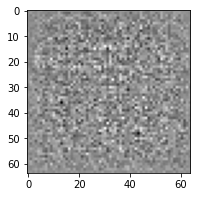

In [44]:
x,y= generate_fake_samples(temp, 100, 1)
plt.figure(figsize=(3,3))
img = x[0]
plt.imshow(img.reshape(64,64), cmap="gray")
plt.show()

In [18]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                           _i9:  1.3 KiB
                           _i2:  1.3 KiB
                          _iii:  1.1 KiB
                          _i15:  1.1 KiB
                          _i11:  1.1 KiB
                    Sequential:  1.0 KiB
                         Model:  1.0 KiB
                     MaxPool2D:  1.0 KiB
                       Dropout:  1.0 KiB
                          Adam:  1.0 KiB
